# Lab 2: Optimize a LLM

This section is to walk through how to optimize a open source model using vLLM tool `llm-compressor` (https://github.com/vllm-project/llm-compressor).

`llm-compressor` is an easy-to-use library for optimizing models for deployment with `vllm`, including:
- Comprehensive set of **quantization** algorithms for weight-only and activation quantization
- Seamless integration with HuggingFace models and repositories
- `safetensors`-based file format compatible with `vllm`
- Large model support via `accelerate`
  
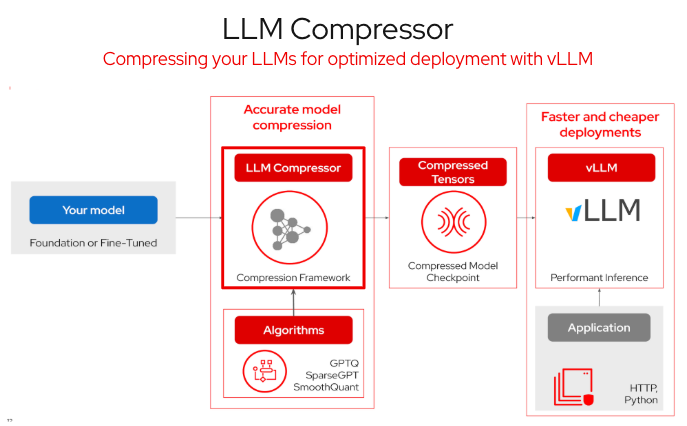

### Why optimize models?

There is a growing disparity between model sizes and available GPU memory. Some of today’s largest MoE architectures now exceed 1.8 trillion parameters. In contrast, even advanced GPUs like Blackwell are limited to 192GB of memory. 

Quantization addresses this gap, significantly reducing the memory required to store and run models. For instance, compressing a 109B model from 220GB in BF16 to 55GB using INT4 (Table 1) allows for single-GPU deployment and lowers compute costs. 

For example:  
Llama4 Scout: 109B parameters
|    Optimization    |     Params size (GiB)   |    GPUs                 |
|--------------------|-------------------------|-------------------------|
|      BFloat16      |     109 * 2 ~= 220 GB   |   3 * 80G (3 * H100)    |
|      INT8/FP8      |     109 * 1 ~= 109 GB   |   2 * 80G (2 * H100)    |
|        INT4        |    109 * 0.5 ~= 55 GB   |   1 * 80G (1 * H100)    |

Similarly, quantizing the 400B-parameter Llama Maverick model from 800GB in BF16 to 200GB using INT4 reduces GPU requirements from a 10-GPU multi-node setup to just 3 GPUs.
Llama4 Maverick: 400B parameters
|    Optimization    |     Params size (GiB)   |    GPUs                 |
|--------------------|-------------------------|-------------------------|
|      BFloat16      |     400 * 2 ~= 800 GB   |  10 * 80G (10 * H100)   |
|      INT8/FP8      |     400 * 1 ~= 400 GB   |   5 * 80G (5 * H100)    |
|        INT4        |   400 * 0.5 ~= 200 GB   |   3 * 80G (3 * H100)    |

Optimization provides several advantages. It reduces memory usage, freeing up GPU RAM for critical components like the KV Cache. It accelerates inference by leveraging low-precision tensor cores available in modern GPUs. And most importantly, it achieves minimal or no degradation in model accuracy. In fact, in some cases, the regularization effects of quantization can even improve performance.

### Here's a real exmple of how to estimate the model sizing

**ibm-granite/granite-3.2-8b-instruct model**

Here's the model card - https://huggingface.co/ibm-granite/granite-3.2-8b-instruct \
Here's the model `config.json` - https://huggingface.co/ibm-granite/granite-3.2-8b-instruct/blob/main/config.json
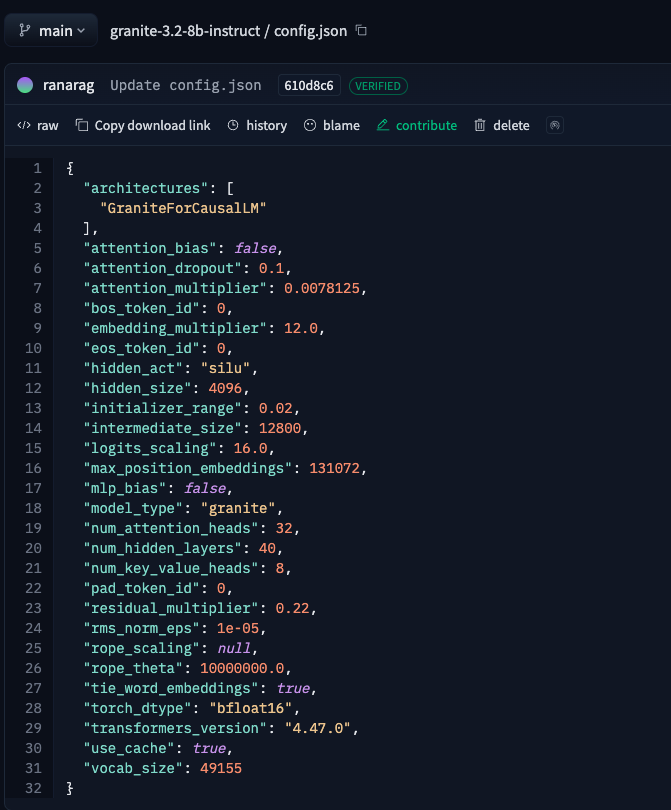

#### Estimation

**Model Card** \
Model size: 8.17B params \
Tensor type: BF16 (2 bytes) \
Number of Hidden Layers: 40 \
Number Key-Value Head: 8 \
Number Attention Head: 32 \
Hidden Size: 4096 (dim per layer) \
Head Size: 128 (Hidden Size / Attention heads) \
Max Context Length: 131072 (Max position embeddings/128K) 

**Model vRAM estimate = Number of Parameters * Model Precision * 20% overhead** \
Model vRAM estimate = 8.17B * BF16(2 bytes) * 1.2 = 18.3 GiB 

**KV Cache estimate = vRAM per token * Context Length * Concurrency** \
vRAM per token = 2 (key & value)  * hidden layers * key-value heads * head size * 2 bytes = 0.16 MiB 

**Concurreny: 1** \
Total KV Cache = 0.16 MiB * 128K * 1 = 20.5 GiB 

**Total vRAM Estimate** = 18.3 + 20.5 = **38.8 GiB**

### Quantization

LLM Compressor supports a wide range of optimization strategies that address different deployment needs. Weight-only schemes like W4A16 are well suited for memory-constrained, low-QPS scenarios. Full quantization using INT8 or FP8 is ideal for high-throughput, compute-intensive deployments. For reducing model size further, 2:4 structured sparsity can be applied. In long-context workloads, quantizing the KV Cache offers additional memory savings.

As Figure 2 illustrates, LLM Compressor sits in the model lifecycle between training and deployment. It takes a Hugging Face-compatible model and applies compression algorithms defined in a modular "recipe." These recipes specify techniques such as round-to-nearest, SmoothQuant, GPTQ, or various sparsity modifiers. 

---
Now, let's try to quantize a model in action.

First, we need install `llmcompressor`.

In [2]:
!pip install llmcompressor==0.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 137.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


---
Make sure llmcompressor library has been installed successfully.

In [3]:
!pip list | grep llmcompressor

llmcompressor             0.5.1


---
Create a python script - `quantize.py`

In [5]:
%%writefile quantize.py

from transformers import AutoTokenizer, AutoModelForCausalLM
from llmcompressor.transformers.compression.helpers import calculate_offload_device_map
from llmcompressor import oneshot
from llmcompressor.modifiers.quantization import QuantizationModifier

# First, we load the target model
#model_stub = "mistralai/Mistral-7B-v0.1"
model_stub = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
device_map = calculate_offload_device_map(
        model_stub,
        reserve_for_hessians=False,
        num_gpus=1,
        torch_dtype="auto"
)
model = AutoModelForCausalLM.from_pretrained(
        model_stub,
        device_map=device_map,
        torch_dtype="auto"
)

# Then, we specify the quantization recipe
recipe = QuantizationModifier(
        targets="linear",
        scheme="FP8_dynamic",
        ignore=["lm_head"]
)

# Then, we apply quantization
oneshot(model=model, recipe=recipe)

# Finally, we save the quantized model to disk
save_path = model_stub + "-FP8-dynamic"
model.save_pretrained(save_path, skip_compression_stats=True, disable_sparse_compression=True)
print(f"Quantized model saved to: {save_path}")

Overwriting quantize.py


In [6]:
!python3 quantize.py

config.json: 100%|█████████████████████████████| 826/826 [00:00<00:00, 4.55MB/s]
model.safetensors.index.json: 24.2kB [00:00, 85.2MB/s]
Fetching 2 files:   0%|                                   | 0/2 [00:00<?, ?it/s]/opt/app-root/lib64/python3.11/site-packages/huggingface_hub/file_download.py:799: UserWarning: Not enough free disk space to download the file. The expected file size is: 8667.83 MB. The target location /opt/app-root/src/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Llama-8B/blobs only has 936.99 MB free disk space.
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/huggingface_hub/file_download.py:799: UserWarning: Not enough free disk space to download the file. The expected file size is: 7392.73 MB. The target location /opt/app-root/src/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Llama-8B/blobs only has 936.98 MB free disk space.
  warnings.warn(

model-00001-of-000002.safetensors:   0%|            | 0.00/8.67G [00:00<?, 